# A Practical Introduction to Causal Inference and Estimation Theory Through Code

This tutorial provides an introduction to causal inference and relevant estimation theory using a practical, code-focused approach, complemented by figures and tables. We will explain key concepts using a well-known example from medical research and show how to calculate the *Average Treatment Effect* using various estimators.

## Learning Goals

* Grasp the causal inference framework for determining the average treatment effect.
* Comprehend the concept of a statistical estimand.
* Learn to design and interpret Monte Carlo simulations to evaluate different estimators.

## Prerequisites

* Basic understanding of probability theory (high school or undergraduate level suffices).
* Familiarity with scientific programming in `Python` or `R`.
* Basic knowledge of supervised learning for classification (e.g., using `sklearn` or `glmnet`).

In this tutorial, we will utilize the following tools and libraries:

In [49]:
import numpy as np                               # Numerical operations
import pandas as pd                              # Data manipulation and analysis
import matplotlib.pyplot as plt                  # Data visualization
from scipy.special import expit                  # Sigmoid function (logistic function)
from sklearn.neural_network import MLPClassifier # Multi-layer perceptron for classification (any non-parametric model could be used)
from sklearn.base import clone                   # Cloning Scikit-Learn models
from joblib import Parallel, delayed             # Parallel processing
from pandas import json_normalize                # Flattening nested JSON objects
import seaborn as sns                            # Statistical data visualization
import time                                      # Time tracking
import datetime                                  # Date and time manipulation

## What is causal inference?

The starting point of the theory of causal inference is the recognition that statistical associations between variables in observational data are not necessarily causal. The goal of causal inference is to establish a conceptual framework to describe *causal* relationships from observed data. In other words, the theory aims to eliminate confounding bias in order to accurately describe the effect of interventions—or actions—on future outcomes.

## Understanding the *Average Treament Effect* (ATE)

* Imagine that in a population of patients, only one characteristic (let's call it X) is relevant to their prognosis and response to a binary treatment. Using this simple, idealized example, we will be able to grasp all the key concepts, making it straightforward to build upon and tackle more complex scenarios later.
* Suppose we know the probability of each patient dying based on this characteristic: i) if they receive the treatment (T=1), and ii) if they do not receive the treatment (T=0).

In [90]:
# Function to simulate the probability of death at 30 days under no treatment
def prob_death_under_no_ttt(X): return expit(np.sin(X))

# Function to simulate the probability of death at 30 days under treatment
def prob_death_under_ttt(X): return expit(0.5*np.sin(X)-.1)

Let's illustrate this concept with a plot.

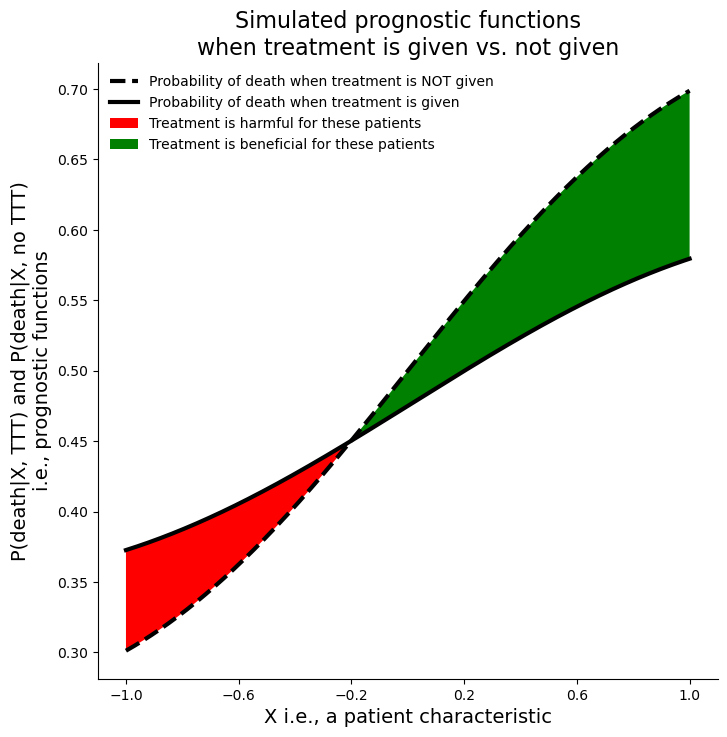

In [91]:
def plot_prob_death(prec=1000):
    x = np.linspace(-1, 1, prec)
    y0 = prob_death_under_no_ttt(x)
    y1 = prob_death_under_ttt(x)
    plt.figure(figsize=(8, 8)) 
    plt.plot(x, y0, color='black', linewidth=3, linestyle='--', label='Probability of death when treatment is NOT given')
    plt.plot(x, y1, color='black', linewidth=3, label='Probability of death when treatment is given')
    plt.fill_between(x, y0, y1, where=(y1 >= y0), facecolor='red', alpha=1, interpolate=True, label='Treatment is harmful for these patients') 
    plt.fill_between(x, y0, y1, where=(y0 > y1), facecolor='green', alpha=1, interpolate=True, label='Treatment is beneficial for these patients') 
    plt.xlabel('X i.e., a patient characteristic', fontsize=14)
    plt.ylabel('P(death|X, TTT) and P(death|X, no TTT)\ni.e., prognostic functions', fontsize=14)
    plt.title('Simulated prognostic functions\nwhen treatment is given vs. not given', fontsize=16)
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
plot_prob_death()

Now, let's examine the benefit of treating each individual patient with characteristic $X = x$.

In [92]:
def plot_individualized_ttt_effects(prec=100000):
    x = np.linspace(-1, 1, prec)
    y = prob_death_under_ttt(x) - prob_death_under_no_ttt(x)
    true_ate = np.mean(y)
    plt.figure(figsize=(7, 7)) 
    plt.axhline(0, color='black', linewidth=1, linestyle='--', label='Line of no treatment effect')
    plt.plot(x[y>=0], y[y>=0], color='red', linewidth=5, label='Treatment is harmful for these patients') 
    plt.plot(x[y<0], y[y<0], color='green', linewidth=5, label='Treatment is beneficial for these patients')
    plt.axhline(true_ate, color='black', linewidth=5, label=f'ATE, assuming a uniform distribution of X ({true_ate*100:.2f}%)')
    plt.xlabel('X i.e., a patient characteristic', fontsize=14)
    plt.ylabel('P(death|X, TTT) - P(death|X, no TTT)\ni.e., conditional treatment effect', fontsize=14)
    plt.title('Simulated conditional treatment effects', fontsize=16)
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    return true_ate

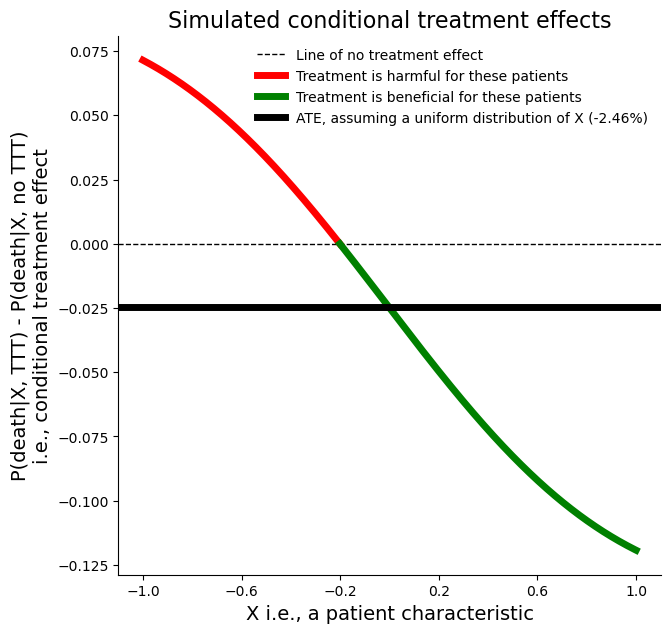

In [93]:
true_ate = plot_individualized_ttt_effects();

By assuming that all patient characteristics $X = x$ are equally likely within the population, the benefit of treating everyone versus treating no one is represented by the solid horizontal line. This is known as the *Average Treatment Effect* (ATE).

## Formalism

### 1. Potential Outcomes
In causal inference, we assume that each patient exists in two copies: i) one in which the patient receives the treatment, and ii) one in which they do not receive the treatment.
We only get to see the outcome for the scenario that corresponds to the treatment the patient actually received in the real world. However, the outcome for the alternate scenario—the one we can't see—also exists. This unobserved outcome is called a latent variable, or in this context, a potential outcome.

The data are independently and identically distributed (i.i.d.) from some distribution $P$:
$$ (X,T,Y, \textcolor{red}{Y^{t=0}, Y^{t=1}}) \overset{\text{iid}}{\sim} P$$
where only $(X,T,Y)$ are observed, and $\textcolor{red}{Y^{t=0}, Y^{t=1}}$ are latent variables known as the potential outcomes.

### 2. Our statistical target, or estimand

The Average Treatment Effect (ATE) is our statistical target, or estimand. It represents the population-level effect of treatment $T=1$ on the outcome $Y$ in a hypothetical infinite randomized trial where the treatment is compared to the control $T=0$. It is formally defined as: It is fromally defined as: $$\Delta \stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}].$$

### 3. Causal Identifiability Assumptions
* **Consistency Assumption (aka Stable Unit Treatment Value Assumption)**: A treatment option is consistent regardless of how it is administered; that is, there are no 'versions' of a treatment option. It is usually stated as: $$Y=TY^{t=1}+(1-T)Y^{t=0}.$$
* **Ignorability Assumption (aka No Unmeasured Confounding Assumption)**: All variables that causally affect both the treatment $T$ and the occurrence of the outcome $Y$ are measured. This assumption is denoted as $$\{Y^{t=0}, Y^{t=1}\} \perp T|X$$
* **Overlap Assumption (aka Positivity Assumption)**: For all realistic levels of $X$, individuals could receive either of the two treatment options with a non-zero probability. This assumption is written as follows: There exists a constant $\eta$ such that:
$$\forall x \in \mathcal{X}, \quad 0 < \eta <  E_P[T|X=x] < 1 - \eta < 1.$$

### 4. Using the Causal Assumptions to Rearrange the Statistical Target and Eliminate the Potential Outcomes
Using the assumptions above, it can be shown that:
$$
\begin{align}
\Delta &\stackrel{\text{def}}{=}E_P[Y^{t=1}-Y^{t=0}] \\
       &= E_P\Big[E_P(Y|T=1,X)-E_P(Y|T=0,X)\Big] \\
       &= E_P\Big[\frac{TY}{E_P[T|X]}-\frac{(1-T)Y}{1-E_P[T|X]}\Big] \\
       &= E_P\Big[E_P(Y|T=1|X)-E_P(Y|T=0|X) + \frac{(2T-1)\{Y-E_P(Y|T,X)\}}{TE_P[T|X]+(1-T)\{1-E_P[T|X]\}}\Big].
\end{align}
$$
Proofs are provided in *Dynamic Treatment Regimes: Statistical Methods for Precision Medicine (CRC Press, 2019), Chapter 2.*
This suggests three estimators for $\Delta$ named G-computation, Inverse Probability Weighting, and Augmented Inverse Probability Weighting, respectively:
$$
\begin{align}
\hat{\Delta}_G &= n^{-1} \sum_{i=1}^n \hat{q}(1,X_i)-\hat{q}(0,X_i) \\
\hat{\Delta}_{IPW} &= n^{-1} \sum_{i=1}^n \frac{T_iY_i}{\hat{e}(X_i)}-\frac{(1-T_i)Y_i}{1-\hat{e}(X_i)} \\
\hat{\Delta}_{AIPW} &= \sum_{i=1}^n \hat{q}(1,X_i)-\hat{q}(0,X_i) + \frac{(2T_i-1)\{Y_i-\hat{q}(T_i,X_i)\}}{T_i\hat{e}(X_i) +(1-T_i)\{1-\hat{e}(X_i)\}}
\end{align}
$$
where:
* $\hat{q}(T,X)$ is an estimator for the prognostic function $E_P(Y|T,X),$ and
* $\hat{e}(X)$ is an estimator for the propensity score function $E_P(T|X)$.
Furthermore, authors have suggested a normalized version of the IPW estimator, which should have better theoretical properties (specifically, a smaller asymptotic variance, as we will see later):
$$
\begin{align}
\hat{\Delta}_{nIPW} &= \sum_{i=1}^n \frac{\frac{T_iY_i}{\hat{e}(X_i)}}{\sum_{i=1}^n\frac{T_i}{\hat{e}(X_i)}}-\frac{\frac{(1-T_i)Y_i}{1-\hat{e}(X_i)}}{\sum_{i=1}^n\frac{1-T_i}{1-\hat{e}(X_i)}}
\end{align}
$$
Our goal in the next section is to *implement* these formulas to see how these estimators perform in practice, but first, let's generate some data.

## Generate Synthetic Data via Monte Carlo Simulations
Consistent with the framework introduced earlier, we will generate data as follows:
$$
\begin{align}
&X \sim \text{Uniform}[-1,1] \\
&T|X \sim \text{Bernoulli}\{e(X)\} \\
&Y^{t=0}|X \sim \text{Bernoulli} \{ q(0,X) \} \\
&Y^{t=1}|X \sim \text{Bernoulli} \{ q(1,X) \} \\
\end{align}
$$
where:
$$
\begin{align}
&e(X) = \cos(X),\\
&q(0,X) = \, \text{expit}\{\sin(X)\}, \, \text{and} \\
&q(1,X) = \, \text{expit}\{\sin(0.5X-0.1)\}.
\end{align}
$$
Let's see how we can implement this in code below.

In [94]:
def generate_data(n_samples):
    # sample X from a uniform distribution
    X = np.random.uniform(-1,1, n_samples)

    # sample from a bernoulli distribution
    T = np.random.binomial(1, np.cos(X), n_samples)
    Y_t0 = np.random.binomial(1, prob_death_under_no_ttt(X), n_samples)
    Y_t1 = np.random.binomial(1, prob_death_under_ttt(X), n_samples)

    # apply the consistency assumption
    Y = T * Y_t1 + (1-T) * Y_t0
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y, 'Y_t0': Y_t0, 'Y_t1': Y_t1})
    

Let's test this data-generating function by creating a superpopulation of 10,000 individuals and checking the first few rows.

In [96]:
# test the function
super_population = generate_data(10000)

# print the first few rows of the dataframe in big font size for better readability
styled_df = super_population.head().style.set_table_styles(
    [{'selector': 'thead th', 'props': [('font-size', '26px')]},
     {'selector': 'tbody td', 'props': [('font-size', '24px')]}]
).set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
display(styled_df)

,X,T,Y,Y_t0,Y_t1
0,0.515847,1,1,0,1
1,0.284245,1,0,1,0
2,-0.198319,1,0,1,0
3,0.421566,1,1,0,1
4,-0.050434,1,0,1,0


## Implement the ATE estimators
### 1. G-computation Estimator

In [ ]:
def g_comp_ate_estimator(data, sk_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - sk_model: a Scikit-Learn model that can predict probabilities of Y given X
    Output:
    - gcomp_ate_estimate (float): the g-computation estimate of the ATE
    - pr_model_t1: the fitted model for predicting Y given X for T == 1
    - pr_model_t0: the fitted model for predicting Y given X for T == 0
    """
    # Prepare prognostic models for T == 1 and T == 0
    pr_model_t1 = clone(sk_model)
    pr_model_t0 = clone(sk_model)
    
    # Get inputs and targets for T == 1 (i.e., subgroup where treatment is given)
    inputs_t1 = data["X"][data["T"]==1].values.reshape(-1, 1)
    targets_t1 = data["Y"][data["T"]==1]
    
    # Fit the model for the subgroup where treatment is given
    pr_model_t1.fit(inputs_t1, targets_t1)

    # For all patients, predict probabilities of death if the treatment were given
    predicted_proba_t1 = pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Get inputs and targets for T == 0 (i.e., subgroup where treatment is not given)
    inputs_t0 = data["X"][data["T"]==0].values.reshape(-1, 1)
    targets_t0 = data["Y"][data["T"]==0].values
    
    # Fit the model for the subgroup where treatment is NOT given
    pr_model_t0.fit(inputs_t0, targets_t0)
    
    # For all patients, predict probabilities of death if the treatment were NOT given
    predicted_proba_t0 = pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Compute the g-computation estimate of the ATE
    gcomp_ate_estimate = np.mean(predicted_proba_t1 - predicted_proba_t0)
    return gcomp_ate_estimate, pr_model_t1, pr_model_t0

Let's test the G-Computation estimator function on a sample of 1,000 individuals from the superpopulation.

In [ ]:
# take a sample of size 10000 from the super_population
data = super_population.iloc[:1000, :3]

# Instantiate a nonparametric classifier (multi-layer perceptron with 20 hidden units here but could be any other model)
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation="logistic", solver="lbfgs", max_iter=5000, random_state=42)

# test the estimator function
g_comp_ate_estimator(data, mlp_model)

(np.float64(-0.12368756355469182),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'))

### 2. IPW and normalized IPW Estimators

In [ ]:
def ipw_ate_estimator(data, sk_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - sk_model: a Scikit-Learn model that can predict probabilities of T given X
    Output:
    - ipw_ate_estimate (float): the IPW estimate of the ATE
    - ipw_ate_estimate_normalized (float): the IPW estimate of the ATE using normalized weights
    - ps_model: the fitted model for predicting T given X
    """
    # Prepare the propensity score model P(T=1|X)
    ps_model = clone(sk_model)
    
    # Get inputs and targets for the propensity score model
    inputs = data["X"].values.reshape(-1, 1)
    targets = data["T"]
    
    # Fit the propensity score model P(T=1|X)
    ps_model.fit(inputs, targets)

    # For all patients, predict probabilities of receiving treatment
    predicted_proba = ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Calculate the weights of the treated as the inverse probabilty of being treated
    w_t1 = data["T"] / predicted_proba
    
    # Calculate the weights of the untreated as the inverse probabilty of being NOT being treated 
    w_t0 = (1 - data["T"]) / (1 - predicted_proba)
    
    # Compute the IPW estimate of the ATE
    ipw_ate_estimate = np.mean((w_t1 - w_t0) * data["Y"])
    
    # Normalize the weights
    w_t1_normalized = w_t1 / np.sum(w_t1)
    w_t0_normalized = w_t0 / np.sum(w_t0)
    
    # Compute the IPW estimate of the ATE using normalized weights
    ipw_ate_estimate_normalized = np.sum((w_t1_normalized - w_t0_normalized) * data["Y"])
    
    return ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model

Let's test the IPW/normalized IPW estimator function on a sample of 1,000 individuals from the superpopulation.

In [98]:
#test the estimator function
ipw_ate_estimator(data, mlp_model)

(np.float64(0.08367416877443898),
 np.float64(-0.03126196966557995),
 MLPClassifier(hidden_layer_sizes=(15,), max_iter=1000, random_state=42))

### 3. AIPW Estimator

In [ ]:
def aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model):
    """
    Input:
    - data: a pandas DataFrame with columns 'X', 'T', and 'Y'
    - gcomp_ate_estimate: the g-computation estimate of the ATE
    - pr_model_t1: the fitted model for predicting Y given X for T == 1
    - pr_model_t0: the fitted model for predicting Y given X for T == 0
    - ps_model: the fitted model for predicting T given X
    Output:
    - aipw_ate_estimate (float): the AIPW estimate of the ATE
    """
    top_left = 2 * data["T"] - 1
    pr_model_preds = data["T"] * pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    top_right = data["Y"] - pr_model_preds
    denominator = data["T"] * ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * (1 - ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1])
    correction_term = top_left * top_right / denominator
    aipw_ate_estimate = gcomp_ate_estimate + np.mean(correction_term)
    return aipw_ate_estimate

### 4. Combining everything into a single function to compute all the estimators mentioned above

In [99]:
def apply_estimators(data, sk_model):
    """
    Input:
    - data: a pandas dataframe containing the data with columns X, T, and Y
    - sk_model: an instance of a scikit-learn classifier
    Output:
    - gcomp_ate_estimate: the g-computation estimate of the ATE
    - ipw_ate_estimate: the IPW estimate of the ATE
    - ipw_ate_estimate_normalized: the IPW estimate of the ATE using normalized weights
    - aipw_ate_estimate: the AIPW estimate of the ATE
    """
    gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, sk_model)
    ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, sk_model)
    aipw_ate_estimate = aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model)
    return gcomp_ate_estimate, ipw_ate_estimate, ipw_ate_estimate_normalized, aipw_ate_estimate

## Compute All Four Estimators on Multiple Equal-Sized Datasets Sampled from the Same Superpopulation
### 1. Define a Simulation class and test it

In [ ]:
class Simulation:
    def __init__(self, s_size, n_sim, generate_data, true_ate, sk_model):
        self.s_size = s_size
        self.n_sim = n_sim
        self.generate_data = generate_data
        self.true_ate = true_ate
        self.sk_model = sk_model
    
    def sim_superpop_and_idxs(self):
        # Create a superpopulation that of size s_size*n_sim
        self.superpop = self.generate_data(self.s_size * self.n_sim)[["X", "T", "Y"]]

        # Create a list of lists of indices for the simulations
        self.sim_idx_s = [range(it * self.s_size, it * self.s_size + self.s_size) for it in range(self.n_sim)]
        self.sim_idx_s = list(map(list, self.sim_idx_s))
        # sim_idx_s is of the form [[0, 1,.., s_size-1], [s_size, s_size+1,.., 2*s_size-1], ...]

        # Confirm that the superpopulation is large enough for the simulation size
        assert self.sim_idx_s[-1][-1] < self.superpop.shape[0], "The dataset is too small for the simulation size (sample size * number of simulations)"
        
    def run_one_simulation(self, sim_idx):
        # Prepare the data for the simulation iteration
        data = self.superpop.iloc[sim_idx]
        gcomp, ipw, ipw_normalized, aipw = apply_estimators(data, self.sk_model)
        
        # Save the results by appending a new row to the results dataframe
        iteration_result = {"iteration": sim_idx[0]//len(sim_idx),
                            "gcomp": gcomp,
                            "ipw": ipw,
                            "ipw_normalized": ipw_normalized,
                            "aipw": aipw}
        return iteration_result

    def run_all_simulations(self):
        # Run all simulations in parallel
        self.results = Parallel(n_jobs=-1)(delayed(self.run_one_simulation)(sim_idx) for sim_idx in self.sim_idx_s)
        # Save the results in a dataframe
        self.results = pd.DataFrame(self.results)
    
    def process_results(self):
        # Calulate bias, variance, MSE and coverage
        estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
        mse = (self.results[estimators] - self.true_ate).pow(2).mean(axis=0)
        bias = self.results[estimators].mean(axis=0) - self.true_ate
        variance = self.results[estimators].var(axis=0) # this is normalized by N-1 by default
        self.analyzed_results = {"n_sim": self.n_sim, "s_size": self.s_size, "mse": dict(mse), "bias": dict(bias), "variance": dict(variance)}

* Let's test this class by generating 999 datasets, each with a sample size of 200, and estimating the ATE using the four estimators on the first dataset.

In [101]:
sim_instance = Simulation(s_size=200, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
sim_instance.sim_superpop_and_idxs()
sim_instance.run_one_simulation(sim_instance.sim_idx_s[0])

{'iteration': 0,
 'gcomp': np.float64(0.043291457772194585),
 'ipw': np.float64(0.17474973221529766),
 'ipw_normalized': np.float64(0.03530192747806343),
 'aipw': np.float64(0.03397700177122558)}

* Now, let's try to estimate the ATE using the four estimators on the second dataset.

In [102]:
sim_instance.run_one_simulation(sim_instance.sim_idx_s[1])

{'iteration': 1,
 'gcomp': np.float64(0.060870297886655586),
 'ipw': np.float64(0.20837692020033138),
 'ipw_normalized': np.float64(0.08236771744307006),
 'aipw': np.float64(0.07483869764566742)}

* Finally, let's estimate the ATE using the four estimators on all 999 datasets.

In [19]:
sim_instance.run_all_simulations()

/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/py

* Let's check the results of computing all four estimators on our 999 datasets.

In [20]:
sim_instance.results

,iteration,gcomp,ipw,ipw_normalized,aipw
0,0,-0.251628,0.007613,-0.232328,-0.255659
1,1,-0.085148,0.116557,-0.098445,-0.070503
2,2,-0.322652,0.206412,-0.239863,-0.325831
3,3,-0.000581,0.089396,-0.159386,-0.069359
4,4,0.270403,0.273895,0.074485,0.248146
...,...,...,...,...,...
994,994,0.061603,0.231375,-0.004073,0.065258
995,995,0.135539,0.239891,0.116190,0.115158
996,996,0.081235,0.289705,0.205624,0.065201
997,997,-0.033285,0.167702,-0.107998,-0.082570


* Analyze the results in terms of MSE, Bias, and Variance of the estimators (we will delve into this in the result section)

In [21]:
sim_instance.process_results()
sim_instance.analyzed_results

{'n_sim': 999,
 's_size': 200,
 'mse': {'gcomp': np.float64(0.024507831646589165),
  'ipw': np.float64(0.046806917466162425),
  'ipw_normalized': np.float64(0.013292863900718856),
  'aipw': np.float64(0.02496710256062068)},
 'bias': {'gcomp': np.float64(0.001160132465914742),
  'ipw': np.float64(0.1880898752643851),
  'ipw_normalized': np.float64(-0.002237200514076533),
  'aipw': np.float64(0.00116226987241317)},
 'variance': {'gcomp': np.float64(0.02453104133618385),
  'ipw': np.float64(0.011440568309520336),
  'ipw_normalized': np.float64(0.013301173322388865),
  'aipw': np.float64(0.024990767472620256)}}

### 2. Run 999 Simulations for 5 Different Sample Sizes Increasing Logarithmically from n=500 to n=10,000

In [105]:
# In this simulation, we will use a MLP model with 15 hidden units as nuisance models
mlp_model = MLPClassifier(hidden_layer_sizes=(15,), max_iter=1000, random_state=42, verbose=False)

In [106]:
# Define the sample sizes for the simulations
s_sizes = np.logspace(np.log10(500.5), np.log10(10000), num=5, dtype=int)
s_sizes

array([  500,  1058,  2237,  4729, 10000])

In [24]:
all_results = []

sim_start_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Starting simulation at {sim_start_time}\n")
for s_size in s_sizes:
    start_time = time.time()
    print(f"Running simulations for sample size n={s_size}...\n")
    
    sim = Simulation(s_size=s_size, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
    sim.sim_superpop_and_idxs()
    sim.run_all_simulations()
    sim.process_results()
    all_results.append(sim)
    
    end_time = time.time()
    hours, rem = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"... took {int(hours)}h {int(minutes)}m {seconds:.1f}s\n")
        
sim_end_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Simulation finished at {sim_end_time}")

Starting simulation at 2024-12-03-12-12-15

Running simulations for sample size n=500...

... took 0h 0m 13.7s

Running simulations for sample size n=1058...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 0m 23.0s

Running simulations for sample size n=2237...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 0m 38.6s

Running simulations for sample size n=4729...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 1m 9.3s

Running simulations for sample size n=10000...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 2m 11.2s

Simulation finished at 2024-12-03-12-16-50


## Interpret the simulation results
### 1. Retrieve the Results from a Monte Carlo Simulation Comparing the Performance of Various Estimators

* Get the raw (float64) results

In [25]:
float_res_df = json_normalize([sim.analyzed_results for sim in all_results])
float_res_df.columns = [col.replace('.', '_') for col in float_res_df.columns]
float_res_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.002332,0.019222,0.004617,0.003917,0.006222,0.125853,0.004681,0.004544,0.002296,0.003386,0.004600,0.003900
1,999,1058,0.001187,0.012648,0.002520,0.002151,0.001352,0.103332,0.000368,0.002058,0.001186,0.001973,0.002522,0.002149
2,999,2237,0.000660,0.008441,0.001346,0.001169,0.000800,0.085468,-0.001637,0.000705,0.000660,0.001137,0.001344,0.001170
3,999,4729,0.000331,0.005840,0.000689,0.000616,0.000131,0.072219,-0.001639,0.000520,0.000331,0.000625,0.000687,0.000616
4,999,10000,0.000177,0.004677,0.000345,0.000318,0.001078,0.065136,-0.000262,0.001552,0.000176,0.000435,0.000345,0.000316


* Enhance the result table for better readability

In [26]:
# Prepare the table for better visualization
# (this part is a bit convoluted and not particulary insighful)
def highlight_cells(x):
    # Create an empty DataFrame with the same shape as x
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    # Apply the mask only to numeric columns
    df.iloc[:, 2:] = 'background-color: gray'
    for col in x.columns:
        if "bias" in col:
            df.loc[:, col] = 'background-color: darkgray'
        for metric in ["mse", "bias", "variance"]:
            if metric in col:
                # gymastic below to remove minus signs as appropriate and compare color the winner estimators in green
                mask = x[col].apply(lambda x: x[1:-1] if x[0] == "-" else x[:-1]) == results_df[[f"{metric}_gcomp", f"{metric}_ipw", f"{metric}_ipw_normalized", f"{metric}_aipw"]].apply(lambda xx: min([x[1:-1] if x[0] == "-" else x[:-1] for x in xx]), axis=1)
                df.loc[mask, col] = 'background-color: green'    
    return df

# Define a custom function to format the values
def format_percentage(x):
    if isinstance(x, float):
        return f"{x * 100:.2f}%"
    return x

# Apply the custom function to all but the first two columns
results_df = float_res_df.astype(object)
results_df.iloc[:, 2:] = results_df.iloc[:, 2:].map(format_percentage)

# Apply the custom function to the DataFrame
styled_results_df = results_df.style.apply(highlight_cells, axis=None).set_table_styles(
    {
        f'{metric}_gcomp': [{'selector': 'td', 'props': [('border-left', '4px solid black')]}] for metric in ["mse", "bias", "variance"]
    }
)

# Display the DataFrame with superheaders
styled_results_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.23%,1.92%,0.46%,0.39%,0.62%,12.59%,0.47%,0.45%,0.23%,0.34%,0.46%,0.39%
1,999,1058,0.12%,1.26%,0.25%,0.22%,0.14%,10.33%,0.04%,0.21%,0.12%,0.20%,0.25%,0.21%
2,999,2237,0.07%,0.84%,0.13%,0.12%,0.08%,8.55%,-0.16%,0.07%,0.07%,0.11%,0.13%,0.12%
3,999,4729,0.03%,0.58%,0.07%,0.06%,0.01%,7.22%,-0.16%,0.05%,0.03%,0.06%,0.07%,0.06%
4,999,10000,0.02%,0.47%,0.03%,0.03%,0.11%,6.51%,-0.03%,0.16%,0.02%,0.04%,0.03%,0.03%


### 2. Visualize the Simulation Results Using Violin Plots for Broader Understanding

In [108]:
# Prepare the data for visualization
# (this part is a bit convoluted and not particulary insighful)
estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
estimates = pd.concat([pd.concat([all_results[i].results[estimator] for estimator in estimators]) for i in range(len(all_results))])
repeated_estimators = [item for item in estimators for _ in range(all_results[0].n_sim)]
repeated_estimators = repeated_estimators * len(all_results)
repeated_s_sizes = [[s_size] * all_results[0].n_sim * len(estimators) for s_size in s_sizes]
repeated_s_sizes = [item for sublist in repeated_s_sizes for item in sublist]
len(repeated_s_sizes), len(repeated_estimators), len(estimates)
# put the results in a dataframe
violin_df = pd.DataFrame({"Estimators": repeated_estimators, "Sample Size": repeated_s_sizes, "Estimations": estimates})
violin_df['Estimators'] = violin_df['Estimators'].replace({
    'gcomp': 'G-computation',
    'ipw': 'IPW',
    'ipw_normalized': 'normalized IPW',
    'aipw': 'AIPW'
})

In [109]:
def plot_violin(violin_df, true_ate):
    plt.figure(figsize=(12, 8))
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    unique_sample_sizes = violin_df['Sample Size'].unique()
    custom_palette = {size: color for size, color in zip(unique_sample_sizes, sns.color_palette("colorblind", len(unique_sample_sizes)))}

    sns.violinplot(x='Estimators', y='Estimations', hue='Sample Size', data=violin_df, split=False, palette=custom_palette)
    plt.axhline(y=true_ate, color='red', linewidth=3, label='True ATE')
    plt.legend(title='Sample Size', frameon=False)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(f'Average Treatment Effect Estimators\nComputed for {all_results[0].n_sim} Simulation Iterations', fontsize=16)
    plt.xlabel('Estimators', fontsize=14)
    plt.ylabel('Estimations', fontsize=14)

    plt.show()

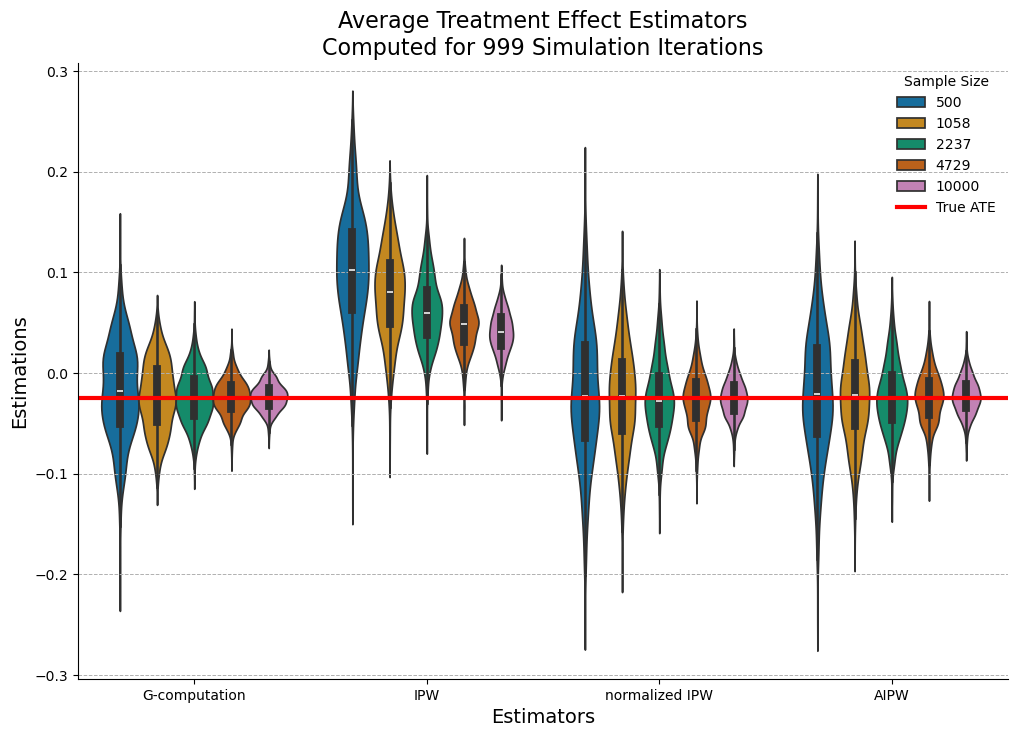

In [29]:
plot_violin(violin_df, true_ate);

### 3. 

In [30]:
loglog_df = pd.concat([np.log(float_res_df["s_size"]), np.log(float_res_df[[col for col in float_res_df.columns if "variance" in col]])], axis=1)
loglog_df.columns = ["log_s_size", "log_variance_gcomp", "log_variance_ipw", "log_variance_ipw_normalized", "log_variance_aipw"]
loglog_df

,log_s_size,log_variance_gcomp,log_variance_ipw,log_variance_ipw_normalized,log_variance_aipw
0,6.214608,-6.076760,-5.687979,-5.381744,-5.546730
1,6.964136,-6.736880,-6.228311,-5.982700,-6.142907
2,7.712891,-7.322791,-6.779401,-6.611976,-6.751083
3,8.461469,-8.012754,-7.378075,-7.282838,-7.391813
4,9.210340,-8.643325,-7.739761,-7.971074,-8.059081


In [45]:
def variance_plot(loglog_df):
    # Define the x-axis and y-axis columns
    x_col = 'log_s_size'
    loglog_df.columns = ["log_s_size", "G-computation", "IPW", "normalized IPW", "AIPW"]
    y_cols = ["G-computation", "IPW", "normalized IPW", "AIPW"]

    # Set the color palette to "colorblind"
    colors = sns.color_palette("colorblind", len(y_cols))

    # Create a scatter plot
    plt.figure(figsize=(8, 8))
    plt.grid(linestyle='--', linewidth=0.7)

    for i, y_col in enumerate(y_cols):
        # Scatter plot
        plt.scatter(loglog_df[x_col], loglog_df[y_col], label=y_col, color=colors[i], marker='o', s=100, zorder=3)
        
        # Calculate the regression line
        slope, intercept = np.polyfit(loglog_df[x_col], loglog_df[y_col], 1)
        regression_line = slope * loglog_df[x_col] + intercept
        
        # Plot the regression line
        plt.plot(loglog_df[x_col], regression_line, color=colors[i], linestyle='--', linewidth=2, label=None, zorder=2)

    # Add labels and legend
    plt.xlabel('Log Sample Size', fontsize=14)
    plt.ylabel('Log Estimator Variance', fontsize=14)
    plt.legend(frameon=True, title='Estimators')
    plt.title('Asymptotic Behavior of Estimators:\nVariances and Convergence Rates', fontsize=16)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the plot
    plt.show()

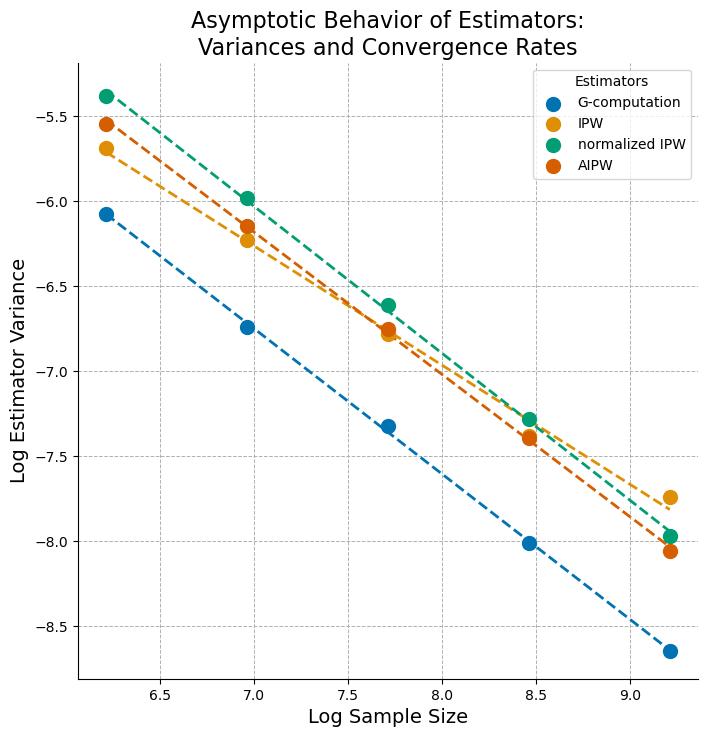

In [46]:
variance_plot(loglog_df)

## Further reading
- LoRA / QLoRA fine-tuning of Gemma 2: [Tutorial 1](https://medium.com/@joansantoso/finetune-your-gemma-model-to-create-a-qa-model-f0380bfba710), [Tutorial 2](https://keras.io/examples/keras_recipes/parameter_efficient_finetuning_of_gemma_with_lora_and_qlora/)
- *Deep Learning with Python, Third Edition*: [pre-relase](https://www.manning.com/books/deep-learning-with-python-third-edition). This book is great! The latest chapters are currently being written and will include numerous code examples for how to use Keras 3 for LLM applications.
---

Tutorial created by François Grolleau on 10/10/2024.